## Streaming data from multiple collections

The next question would be: how can we stream data from multiple collections?

We assume that we want to stream data for the same spatial location (same bbox) but from multiple datasets. Given this assumption, how can we achieve it?

In [63]:
import pystac_client
DC_URL = 'https://datacube.services.geo.ca/stac/api/'
catalog = pystac_client.Client.open(DC_URL)  

In [64]:
collections = list(catalog.get_collections())
for collection in sorted(collections, key=lambda col: col.id):
    print(collection.id)

canadian-wetland-inventory
cancvi
cdem
cdsm
dynamic-surface-water-annual
dynamic-surface-water-compilation
et-month
et-year
flood-susceptibility
hrdem-arcticdem
hrdem-lidar
hrdem-mosaic-1m
hrdem-mosaic-2m
inland-water
landcover
monthly-vegetation-parameters-20m-v1
mrdem-30
msi
napl-halifax
napl-markham
napl-ottawa
napl-regina
napl-ring-of-fire
napl-salish
napl-tuktoyaktuk
napl-victoria
pet-month
pet-year
rcm-ard-mosaic
river-ice-canada-archive
surface-water-frequency
vegetation


Now, we have decided to go with the **hrdem-lidar** and **landcover** collections.

In [87]:
collections = ['hrdem-lidar', 'landcover']

In [88]:
datetime_range = '2019-01-01/2024-12-31'

In [89]:
bbox = [-114.00, 51.24, -113.94, 51.33]

Now, with these three basic filters, we can search the STAC API endpoint to retrieve the STAC items that may be available.

In [90]:
stac_items     = catalog.search(collections = collections, 
                                bbox = bbox, 
                                datetime = datetime_range
                               )

In [91]:
def reorder_transform(gdal_transform):
    return [gdal_transform[1], gdal_transform[2], gdal_transform[0],
            gdal_transform[4], gdal_transform[5], gdal_transform[3], 
            0, 0, 1]

In [92]:
stac_found_items = [item for item in stac_items.items()]
for item in stac_found_items:
    if "proj:transform" in item.properties:
        proj_transform = item.properties["proj:transform"]
        if isinstance(proj_transform, list):
            item.properties["proj:transform"] = reorder_transform(proj_transform)
    else:
        print(f"Item {item.id} does not have proj:transform in properties.")

Now, we need to create a dictionary where the keys will be the names of the collections, and the values will be a list of bands that we want to read from each collection.

In [93]:
for item in stac_found_items:
    print(item.assets.keys())
    print(item.get_collection().id)

dict_keys(['dsm', 'dtm', 'extent', 'dsm-vrt', 'dtm-vrt', 'coverage', 'thumbnail'])
hrdem-lidar
dict_keys(['dsm', 'dtm', 'extent', 'dsm-vrt', 'dtm-vrt', 'coverage', 'thumbnail'])
hrdem-lidar
dict_keys(['thumbnail', 'classification'])
landcover


In [94]:
collections_dict = {"hrdem-lidar" : ['dsm', 'dtm'], "landcover" : ['classification']}

Also, I want to load data from different time steps for each collection.

For each collection, if multiple assets have the exact same timestamp, we should load only one of them.

In [95]:
import odc.stac


datasets = []
seen_pairs = set()  # Track (date, collection) pairs

for item in stac_found_items:
    ds = odc.stac.load(
         [item],
         chunks     = {"x": 1000, "y": 1000},
         bands      = collections_dict[item.get_collection().id],
         bbox       = bbox,
         resolution = 1.0)
    
    # Extract date and collection name
    ds_date = str(ds.time.values[0]) 
    collection_name = item.get_collection().id
    pair = (ds_date, collection_name)

    if pair not in seen_pairs:
        seen_pairs.add(pair)  
        datasets.append(ds)    

print(datasets)

[<xarray.Dataset> Size: 590MB
Dimensions:      (y: 10713, x: 6887, time: 1)
Coordinates:
  * y            (y) float64 86kB 4.527e+05 4.527e+05 ... 4.42e+05 4.42e+05
  * x            (x) float64 55kB -1.297e+06 -1.297e+06 ... -1.29e+06 -1.29e+06
    spatial_ref  int32 4B 3979
  * time         (time) datetime64[ns] 8B 2020-10-08T12:00:00
Data variables:
    dsm          (time, y, x) float32 295MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    dtm          (time, y, x) float32 295MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>, <xarray.Dataset> Size: 295MB
Dimensions:         (y: 10713, x: 6887, time: 1)
Coordinates:
  * y               (y) float64 86kB 4.527e+05 4.527e+05 ... 4.42e+05 4.42e+05
  * x               (x) float64 55kB -1.297e+06 -1.297e+06 ... -1.29e+06
    spatial_ref     int32 4B 3979
  * time            (time) datetime64[ns] 8B 2020-07-01T12:00:00
Data variables:
    classification  (time, y, x) float32 295MB dask.array<chunksize=(1, 1000, 1000), meta

Now, we have a list of all the xarray datasets that we need.

Next, we can merge them into a single dataset that contains all the data variables.

Time is not an important variable for me, and it is the only dimension varying among my data items. All data items have the same x and y coordinates but different time values, which I do not need.

So, I overwrite the time dimension whenever I read data into my xarray dataset. When merging, I override the time dimension, ensuring that the final dataset retains the time value from the first dataset in my dataset list.

In [96]:
import xarray
xrDS = xarray.merge(datasets, join="override")

In [82]:
xrDS

<xarray.Dataset> Size: 886MB
Dimensions:         (y: 10713, x: 6887, time: 1)
Coordinates:
  * y               (y) float64 86kB 4.527e+05 4.527e+05 ... 4.42e+05 4.42e+05
  * x               (x) float64 55kB -1.297e+06 -1.297e+06 ... -1.29e+06
    spatial_ref     int32 4B 3979
  * time            (time) datetime64[ns] 8B 2020-10-08T12:00:00
Data variables:
    dsm             (time, y, x) float32 295MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    dtm             (time, y, x) float32 295MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    classification  (time, y, x) float32 295MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

In [57]:
xrDS =   xrDS.compute()

Let's compute and visualize the results! 

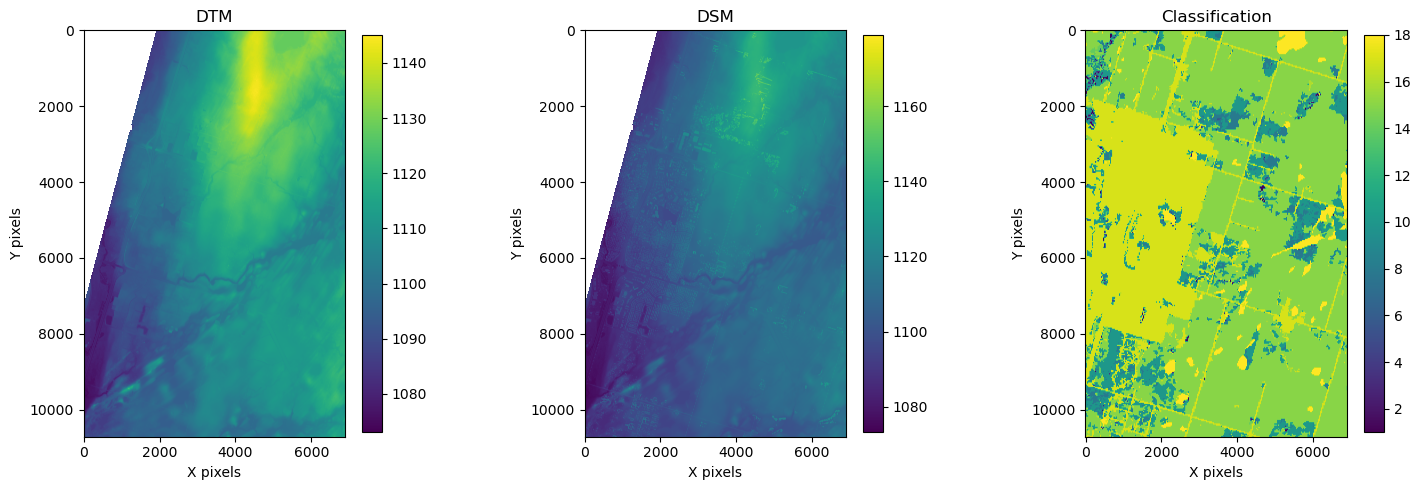

In [83]:
import rasterio
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figure size as needed
arrays = [xrDS["dtm"].data[0, :, :], xrDS["dsm"].data[0, :, :], xrDS["classification"].data[0, :, :]]
titles = ["DTM", "DSM", "Classification"]

for ax, arr, title in zip(axes, arrays, titles):
    img = ax.imshow(arr, cmap="viridis") 
    ax.set_title(title)
    ax.set_xlabel("X pixels")
    ax.set_ylabel("Y pixels")
    fig.colorbar(img, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)  

plt.tight_layout()  
plt.show()
